#  Testing Overlap Algorithms on Mixed States
This notebook will test our swap test and BBA implementations that compute the overlap Tr$({\rho^{A}}^2)$, where now $\rho^{A}$ is a reduced density matrix of some density matrix $\rho$.

In [1]:
from sys import path
path.insert(0, '..')

from bba import *
from swap import *
from utilities import *
import numpy as np
import matplotlib.pyplot as plt

Let

$$
|\psi> = \frac{1}{2}\left( \sqrt{1+r}\left(|00>+ |01>\right)+\sqrt{1-r}\left(|10> - |11>\right)\right)
$$
where $0\leq r \leq 1$. Then the reduced density matrix for the first qubit is
$$\rho^{A} = \frac{I + r\sigma_{z}}{2}$$

Note that when $r=0$, $\rho^{A}$ is a maximally entangled state, and when $r=1$, $\rho^{A}$ is a pure state.

Let's construct the quantum circuits representing these wavefunctions:

In [2]:
r = .5
psi = psi2_qc(r)          #quantum circuit
psi_c = psi2_classical(r) #classical representation

The circuit for $|\psi>$ is drawn below:

In [3]:
psi.draw()

┌──────────┐   
q_0: ┤ RY(pi/3) ├─■─
     └──┬───┬───┘ │ 
q_1: ───┤ H ├─────■─
        └───┘

Now, let's look at the swap test quantum circuit with this wavefuntion:

In [4]:
#constructing the swap circuit
qc_swap = swap_test_QC(psi, psi, [0])
qc_swap.draw()

┌───┐          ┌───┐┌─┐
  a_0: ───┤ H ├────────■─┤ H ├┤M├
       ┌──┴───┴───┐    │ └───┘└╥┘
psi_0: ┤ RY(pi/3) ├─■──X───────╫─
       └──┬───┬───┘ │  │       ║ 
psi_1: ───┤ H ├─────■──┼───────╫─
       ┌──┴───┴───┐    │       ║ 
phi_0: ┤ RY(pi/3) ├─■──X───────╫─
       └──┬───┬───┘ │          ║ 
phi_1: ───┤ H ├─────■──────────╫─
          └───┘                ║ 
  m_0: ════════════════════════╩═

And now, for BBA

In [5]:
#constructing the bba circuit
qc_swap = bba_QC(psi, psi, [0])
qc_swap.draw()

┌──────────┐        ┌───┐┌─┐
psi_0: ┤ RY(pi/3) ├─■───■──┤ H ├┤M├
       └──┬───┬───┘ │   │  └───┘└╥┘
psi_1: ───┤ H ├─────■───┼────────╫─
       ┌──┴───┴───┐   ┌─┴─┐ ┌─┐  ║ 
phi_0: ┤ RY(pi/3) ├─■─┤ X ├─┤M├──╫─
       └──┬───┬───┘ │ └───┘ └╥┘  ║ 
phi_1: ───┤ H ├─────■────────╫───╫─
          └───┘              ║   ║ 
  m_0: ══════════════════════╬═══╩═
                             ║     
  m_1: ══════════════════════╩═════

Now we run the simulation and obtain the overlap. Then we compare to the exact results:

In [6]:
overlap_qc = swap_overlap(psi, psi, idx_list=[0], shots=100000, noise=True)
overlap_bb =  bba_overlap(psi, psi, idx_list=[0], shots=100000, noise=True)
overlap_cl = classical_partial_overlap(psi_c, psi_c)


ibmqfactory.load_account:WARNING:2020-06-28 19:22:03,692: Credentials are already in use. The existing account in the session will be replaced.


In [7]:
print("swap test overlap: {}".format(overlap_qc))
print("      bba overlap: {}".format(overlap_bb))
print("    exact overlap: {}".format(overlap_cl))
print("")
print("       swap error: {}".format(np.abs(overlap_qc-overlap_cl)))
print("        bba error: {}".format(np.abs(overlap_bb-overlap_cl)))

swap test overlap: 0.5385599999999999
      bba overlap: 0.6270000000000001
    exact overlap: 0.6249999999999999

       swap error: 0.08643999999999996
        bba error: 0.002000000000000224


Now let's look at how these overlaps compare as we tune $r$

In [12]:
N = 100
r_list = np.linspace(0, 1, N)
o_qc_list = np.zeros(N)
o_bb_list = np.zeros(N)
o_cl_list = np.zeros(N)
sw_err_list = np.zeros(N)
bb_err_list = np.zeros(N)

for i, r in enumerate(r_list):
    psi = psi2_qc(r)
    psi_c = psi2_classical(r)
    o_qc_list[i] = swap_overlap(psi, psi, idx_list=[0], shots=10000, noise=False)
    o_bb_list[i] =  bba_overlap(psi, psi, idx_list=[0], shots=10000, noise=False)
    o_cl_list[i] = classical_partial_overlap(psi_c, psi_c)
    sw_err_list[i] = np.abs(o_qc_list[i] - o_cl_list[i])   
    bb_err_list[i] = np.abs(o_bb_list[i] - o_cl_list[i])   

<IPython.core.display.Javascript object>


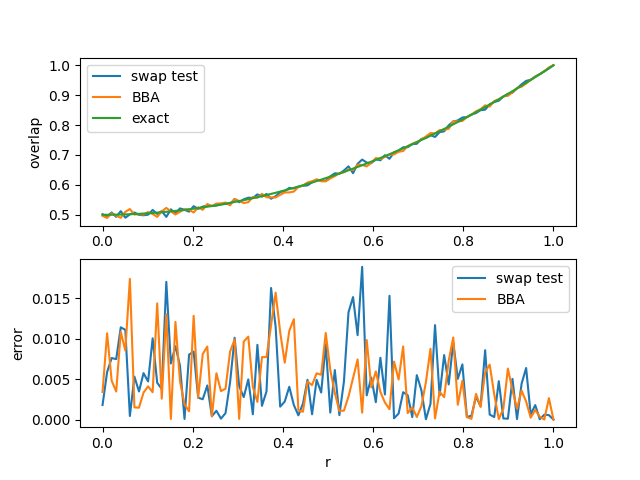

In [13]:
%matplotlib notebook

plt.subplot(211)
plt.plot(r_list, o_qc_list, label="swap test")
plt.plot(r_list, o_bb_list, label="BBA")
plt.plot(r_list, o_cl_list, label="exact")

plt.legend(loc='best')
plt.ylabel("overlap")
plt.subplot(212)
plt.plot(r_list, sw_err_list, label="swap test")
plt.plot(r_list, bb_err_list, label="BBA")
plt.xlabel("r")
plt.ylabel("error")
plt.legend(loc='best')
plt.show()